In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta as td

sys.path.append("..")
from lsh.similarity import TimeSeriesLSH


In [3]:
def read_metric(series_path):
    return pd.read_csv(f"../data/NAB/{series_path}").rename(columns={"value": "y"})


In [4]:
metric = read_metric('realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv')

In [5]:
metric['timestamp'] = pd.to_datetime(metric['timestamp'], infer_datetime_format=True)
metric = metric.sort_values(by='timestamp')

In [6]:
metric.head()

,timestamp,y
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


/anaconda3/envs/time-series/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([735279., 735281., 735283., 735285., 735287., 735289., 735291.,
        735293.]), <a list of 8 Text xticklabel objects>)

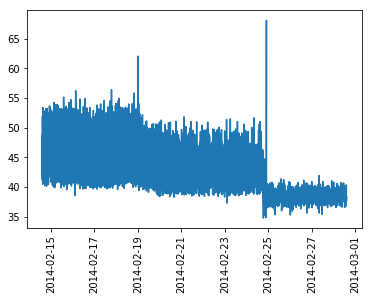

In [7]:
plt.plot(metric['timestamp'], metric['y'])
plt.xticks(rotation='vertical')

In [8]:
grouped_by_hour = metric.groupby(
     [metric['timestamp'].map(lambda x : x.year).rename('year'),
      metric['timestamp'].map(lambda x : x.month).rename('month'),
      metric['timestamp'].map(lambda x : x.day).rename('day'),
      metric['timestamp'].map(lambda x : x.hour).rename('hour')]).count()
grouped_by_hour

timestamp   y
year month day hour               
2014 2     14  14            7   7
               15           12  12
               16           12  12
               17           12  12
               18           12  12
               19           12  12
               20           12  12
               21           12  12
               22           12  12
               23           12  12
           15  0            12  12
               1            12  12
               2            12  12
               3            12  12
               4            12  12
               5            12  12
               6            12  12
               7            12  12
               8            12  12
               9            12  12
               10           12  12
               11           12  12
               12           12  12
               13           12  12
               14           12  12
               15           12  12
               16           12  12
               17           12  12
               18           12  12
               19           12  12
...                        ...  ..
           27  9            12  12
               10           12  12
               11           12  12
               12           12  12
               13           12  12
               14           12  12
               15           12  12
               16           12  12
               17           12  12
               18           12  12
               19           12  12
               20           12  12
               21           12  12
               22           12  12
               23           12  12
           28  0            12  12
               1            12  12
               2            12  12
               3            12  12
               4            12  12
               5            12  12
               6            12  12
               7            12  12
               8            12  12
               9            12  12
               10           12  12
               11           12  12
               12           12  12
               13           12  12
               14            5   5

[337 rows x 2 columns]

In [9]:
def split_series(series, response_variable = 'y'):
    number_of_hours = 6
    series = series.sort_values(by='timestamp')
    start_date = pd.Timestamp(series['timestamp'][0]) - pd.Timedelta(hours = int(number_of_hours / 2))
    end_date = pd.Timestamp(series['timestamp'][0]) + pd.Timedelta(hours = int(number_of_hours / 2))
    series_begin = pd.Timestamp(series['timestamp'][0])
    series_end = pd.Timestamp(series['timestamp'][len(series['timestamp']) - 1])

    hour_in_nanos = 1000 * 1000 * 1000 * 60 * 60
    total_hours = int((series_end - series_begin).delta / hour_in_nanos)
    number_of_windows = int(total_hours / number_of_hours + 1)
    result = []
    
    for hour in range(0, number_of_windows):
        start_date = start_date + pd.Timedelta(hours = int(number_of_hours / 2))
        end_date = end_date + pd.Timedelta(hours = int(number_of_hours / 2))
        mask = (series['timestamp'] > start_date) & (series['timestamp'] <= end_date)
        subseries = series.loc[mask]
        result.append(subseries)
    return result

def show_metric(windows, num):
    metric_window = windows[num]
    plot_metric(windows[num])

def plot_metric(metric):
    plt.plot(metric['timestamp'], metric['y'])
    plt.xticks(rotation='vertical')

def find_window_max(windows, response_variable = 'y'):
    max_response = 0
    max_window = None
    max_idx = 0
    for idx, window in enumerate(windows):
        current_max = window[response_variable].max()
        if current_max > max_response:
            max_response = current_max
            max_window = window
            max_idx = idx
    return max_idx, max_window        

metric_windows = split_series(metric)

In [10]:
len(metric_windows)

56

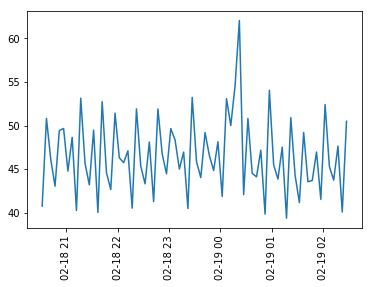

In [11]:
idx, window = find_window_max(metric_windows)
# print(idx, window)
show_metric(metric_windows, idx)

In [12]:
hash_index = TimeSeriesLSH(W = 10, shingle_size = 15)

In [13]:
hash_index.fit(metric_windows)

In [14]:
suspicious = metric_windows[idx]
result = hash_index.query(suspicious)
result.sort(key = lambda v: v["similarity"], reverse = True)

idx: 34,obj: 2014-02-18T20:32:00.000000000, similarity: 1.0.
idx: 1,obj: 2014-02-14T17:32:00.000000000, similarity: 0.0625.
idx: 13,obj: 2014-02-16T05:32:00.000000000, similarity: 0.0390625.
idx: 35,obj: 2014-02-18T23:32:00.000000000, similarity: 0.03125.
idx: 36,obj: 2014-02-19T02:32:00.000000000, similarity: 0.03125.
idx: 30,obj: 2014-02-18T08:32:00.000000000, similarity: 0.015625.
idx: 40,obj: 2014-02-19T14:32:00.000000000, similarity: 0.0078125.


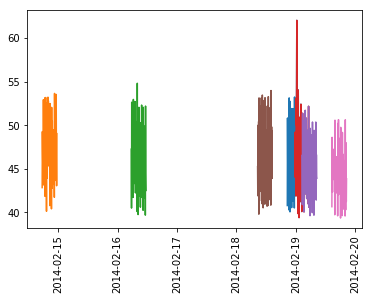

In [15]:
def print_similar(windows, result):
    for item in result:
        print(f"idx: {item['object']['idx']},obj: {item['object']['series']['timestamp'].values[0]}, similarity: {item['similarity']}.")
    for item in result:
        plot_metric(item['object']['series'])
print_similar(metric_windows, result)


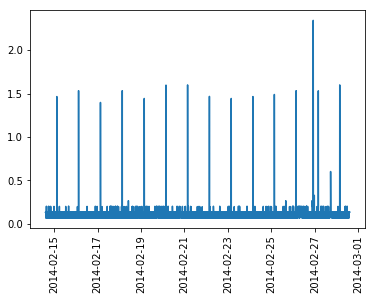

In [16]:
metric_ec2_cpu_utilization_24ae8d = read_metric('realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv')
metric_ec2_cpu_utilization_24ae8d['timestamp'] = pd.to_datetime(metric_ec2_cpu_utilization_24ae8d['timestamp'], infer_datetime_format=True)
metric_ec2_cpu_utilization_24ae8d = metric_ec2_cpu_utilization_24ae8d.sort_values(by='timestamp')
plt.plot(metric_ec2_cpu_utilization_24ae8d['timestamp'], metric_ec2_cpu_utilization_24ae8d['y'])
plt.xticks(rotation='vertical')
metric_windows_metric_ec2_cpu_utilization_24ae8d = split_series(metric_ec2_cpu_utilization_24ae8d)

In [17]:
hash_index.fit(metric_windows_metric_ec2_cpu_utilization_24ae8d)

In [18]:
result = hash_index.query(suspicious)
result.sort(key = lambda v: v["similarity"], reverse = True)
result = result[1:14]

idx: 19,obj: 2014-02-16T23:35:00.000000000, similarity: 0.1484375.
idx: 20,obj: 2014-02-17T02:35:00.000000000, similarity: 0.1328125.
idx: 4,obj: 2014-02-15T02:35:00.000000000, similarity: 0.09375.
idx: 12,obj: 2014-02-16T02:35:00.000000000, similarity: 0.09375.
idx: 28,obj: 2014-02-18T02:35:00.000000000, similarity: 0.0859375.
idx: 44,obj: 2014-02-20T02:35:00.000000000, similarity: 0.0859375.
idx: 52,obj: 2014-02-21T02:35:00.000000000, similarity: 0.0859375.
idx: 11,obj: 2014-02-15T23:35:00.000000000, similarity: 0.078125.
idx: 36,obj: 2014-02-19T02:35:00.000000000, similarity: 0.0703125.
idx: 43,obj: 2014-02-19T23:35:00.000000000, similarity: 0.0703125.
idx: 51,obj: 2014-02-20T23:35:00.000000000, similarity: 0.0703125.
idx: 1,obj: 2014-02-14T17:32:00.000000000, similarity: 0.0625.
idx: 3,obj: 2014-02-14T23:35:00.000000000, similarity: 0.0625.


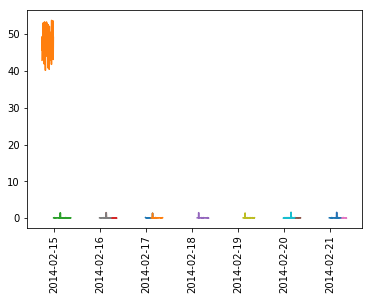

In [19]:
print_similar(metric_windows_metric_ec2_cpu_utilization_24ae8d, result)

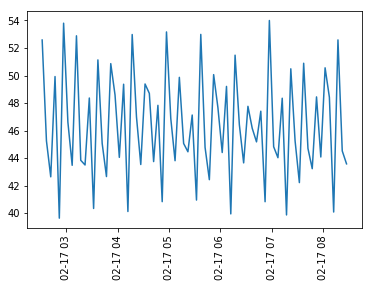

In [20]:
show_metric(metric_windows, 20)